In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import pi, sqrt
from scipy.stats import unitary_group
from scipy.special import erf 

def success_prob_calc(Δ):
    return (erf( (pi**0.5)/(2*Δ) )- erf(-(pi**0.5)/(2*Δ) )  )/2

def Hilbertspace_Zr(N,r):
    states=np.zeros((r**N,N),dtype=int)
    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states
def u3_error_gkp(σc2, σgkp2, σm2,k):

    σin = (2**0.5) * (k*(2*σgkp2 + 17/6*σc2))**0.5
    σout = (2**0.5) * (σgkp2 + σm2)**0.5
    
    σn = (2**0.5) * (3*σgkp2+ 11/3*σc2 + σm2)**0.5
    Xerr = 1-success_prob_calc(σn)
    σn = (2**0.5) * ( (3*σgkp2+ 11/3*σc2+ σgkp2+ 2*σc2)/2 + σm2)**0.5
    Yerr = 1-success_prob_calc(σn)
    #check the factor
    Nerr = 2*(1-success_prob_calc(σin))/3 + (1-success_prob_calc(σout))
    
    prob_X = 2*Nerr*(1-Nerr)**2*(1-Xerr)+2*Nerr**2*(1-Nerr)*(Xerr)
    prob_Z = Nerr*(1-Nerr)**2*(1-Xerr)+ Xerr*(1-Nerr)**2*(1-Nerr)+(1-Xerr)*Nerr**3+Xerr*(1-Nerr)*Nerr**2
    prob_Y = 2*Nerr*Xerr*(1-Nerr)**2 + 2*Nerr*Nerr*(1-Xerr)* (1-Nerr)
    total_error = prob_X + prob_Z + prob_Y
    
    return [('I',1 - total_error), ('X',prob_X),('Y',prob_Y),('Z',prob_Z)]


def cnot_error_gkp(σc2, σgkp2, σm2):
    #Calculate the raw error rates
    Nq = 13
    vec = Hilbertspace_Zr(Nq,2)

    # qubits measured in X or Y basis
    X_list = [0,7,8,9,11,12]
    Y_list = [1,2,3,4,5,6,10]
    Nx = len(X_list)+1
    Ny = len(Y_list)+1

    err_vec = np.zeros((16,Ny*Nx),dtype=int)
    for i in range(2**Nq):
        s_flip=vec[i,:]

        sz_c = np.sum(vec[i,[0,2,3,4,6,7,9]])
        sx_c = np.sum(vec[i,[1,2,4,5]])
        sz_t = np.sum(vec[i,[7,9,11]])
        sx_t = np.sum(vec[i,[1,2,6,8,10,12]])
        px_exp = np.sum(vec[i,X_list])
        py_exp = np.sum(vec[i,Y_list])

        i_e = np.array([sz_c%2,sx_c%2,sz_t%2,sx_t%2])@ (2**np.arange(4))
        err_vec[i_e,py_exp*Nx + px_exp] += 1

    err_prob = np.zeros(16)

    σn = (2**0.5) * ( 3*σgkp2+ 11/3*σc2 + σm2)**0.5
    Xerr = 1-success_prob_calc(σn)
    px_vec = Xerr**np.arange(Nx)*(1-Xerr)**np.arange(Nx-1,-1,-1)
    σn = (2**0.5) * ( (3*σgkp2+ 11/3*σc2+ σgkp2+ 2*σc2)/2 + σm2)**0.5
    Yerr = 1-success_prob_calc(σn)
    py_vec = Yerr**np.arange(Ny)*(1-Yerr)**np.arange(Ny-1,-1,-1)
    p_vec = np.kron(py_vec,px_vec)
    err_prob = err_vec @ p_vec    
    
    err_list={0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_prob[i]))
    
    return err_model


def error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'U3'): 
    #a wrapper function that, given a Gaussian noise distribution, returns a noise channel
    '''
    σgkp2: GKP error
    σc2: CZ error 
    σm2: measurement error
    '''
    if gate_type == 'U3':
        error_model = u3_error_gkp(σc2, σgkp2, σm2, k)
        
    elif gate_type == 'CNOT':
        error_model = cnot_error_gkp(σc2, σgkp2, σm2)
    else:
        raise NotImplementedError('Shit, the requested gate type is not implemented')
    return error_model


cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])+0j

def pauli(s):
    s0 = np.matrix([[1.,0.],[0.,1.]])
    s1 = np.matrix([[0.,1.],[1.,0.]])
    s2 = np.matrix([[0.,-1.j],[1.j,0.]])
    s3 = np.matrix([[1.,0.],[0.,-1.]])
    if s == 'I':
        return s0 
    elif s =='X':
        return s1
    elif s == 'Y':
        return s2
    elif s == 'Z':
        return s3
    
def pauli_str_to_mat(string):
    U = pauli(string[0])
    for k in range(1,len(string)):
        U =np.kron(U, pauli(string[k]))
    return U

def error_channel(U_in, error_model):
    U_out = np.zeros([4,4])+0.j
    for i in range (16):
        U_out += error_model[i][1]*pauli_str_to_mat(error_model[i][0])@cnot@U_in@cnot@pauli_str_to_mat(error_model[i][0])
    return U_out

def fidelity_CNOT(error_model): # input a error model; out put the average fid. based on https://arxiv.org/pdf/quant-ph/0205035.pdf   
    err_list= {0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    fid = 0.2
    for i in range (16):
        U_in = pauli_str_to_mat(err_list[i])
        U_out = error_channel(U_in, error_model)
        fid += np.trace(cnot@np.conj(U_in.T)@cnot@U_out)/80
    return fid
    

/Users/yuxuzhan/opt/anaconda3/envs/MBQC/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


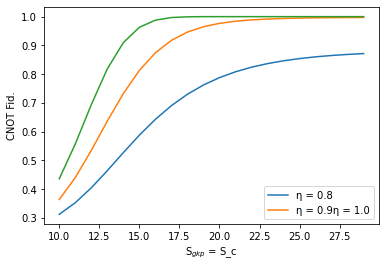

In [5]:
error_model = error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'CNOT')
fidelity_CNOT(error_model)
dBs = np.arange(10,30,1)
η_list = [0.8,.9,1]# homodyne measurement efficiency
for η in η_list:
    fids = []
    for dB in dBs:
        σ2 = 10**(-1/10*dB)/2
        σm2 = (1-η)/(2*η)
        σgkp2 = σc2 = σ2
        error_model = error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'CNOT')
        fids.append(fidelity_CNOT(error_model))
    plt.plot(dBs,fids)
plt.xlabel('S$_{gkp}$ = S_c')
plt.ylabel('CNOT Fid.')
plt.legend(['η = 0.8','η = 0.9''η = 1.0'])
plt.savefig('CNOT_fid.pdf')